# Building Your First GAN with PyTorch

## Deep Convolutional GANs

DCAGN (Deep Convolutional Generative Adversarial Network) is one of the early well-performing and stable approaches to generate images with adversarial training. Even when we only train a GAN to manipulate 1D data, we have to use multiple techniques to ensure a stable training. A lot of things could go wrong in the training of GANs. For example, either a generator or a discriminator could overfit if one or the other does not converge. Sometimes, the generator only generates a handful of sample varieties. This is called mode collapse.

To ensure the stable training of GANs on image data like this, a DCGAN uses three techniques:

- Getting rid of fully connected layers and only using convolution layers 
- Using strided convolution layers to perform downsampling, instead of using pooling layers
- Using ReLU/leakyReLU activation functions instead of Tanh between hidden layers

In this lecture, we will introduce the architectures of the generator and discriminator of the DCGAN and learn how to generate images with it. We'll use a spectrogram dataset I generated for this lectures.

# The architecture of generator

The generator network of a DCGAN contains 4 hidden layers (we treat the input layer as the 1 st hidden layer for simplicity) and 1 output layer. Transposed convolution layers are used in hidden layers, which are followed by batch normalization layers and ReLU activation functions. The output layer is also a transposed convolution layer and Tanh is used as the activation function. The architecture of the generator is shown in the following diagram:

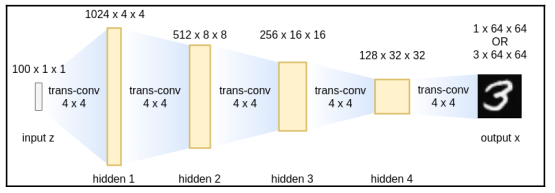

The $2^{nd} , 3^{rd}$ , and $4^{th}$ hidden layers and the output layer have a stride value of 2. The 1 st layer has a padding value of 0 and the other layers have a padding value of 1. As the image (feature map) sizes increase by two in deeper layers, the numbers of channels are decreasing by half. This is a common convention in the architecture design of neural networks. All kernel sizes of transposed convolution layers are set to 4 x 4. The output channel can be either 1 or 3, depending on whether you want to generate grayscale images or color images.

## !!!!
The transposed convolution layer can be considered as the reverse process of a normal convolution. It was once called by some a deconvolution layer, which is misleading because the transposed convolution is not the inverse of convolution. Most convolution layers are not invertible, because they are ill-conditioned (have extremely large condition numbers) from the linear algebra perspective, which makes their pseudoinverse matrices unfit for representing the inverse process.

# The architecture of a discriminator

The discriminator network of a DCGAN consists of 4 hidden layers (again, we treat the input layer as the 1 st hidden layer) and 1 output layer. Convolution layers are used in all layers, which are followed by batch normalization layers except that the first layer does not have batch normalization. LeakyReLU activation functions are used in the hidden layers and Sigmoid is used for the output layer. The architecture of the discriminator is shown in the following:

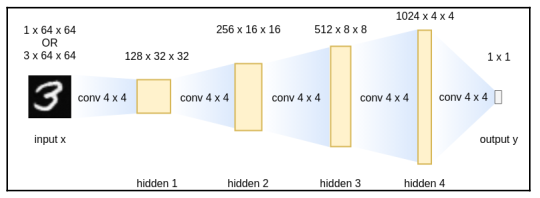

The input channel can be either 1 or 3, depending on whether you are dealing with grayscale images or color images. All hidden layers have a stride value of 2 and a padding value of 1 so that their output image sizes will be half the input images. As image sizes increase in deeper layers, the numbers of channels are increasing by twice. All kernels in convolution layers are of a size of 4 x 4. The output layer has a stride value of 1 and a padding value of 0. It maps 4 x 4 feature maps to single values so that the Sigmoid function can transform the value into prediction confidence.

# Creating a DCGAN with PyTorch

In [ ]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from pathlib import Path

In [ ]:
CUDA = True
DATA_PATH = Path('../datasets/pure_redux/')
OUT_PATH = Path('./outputs/')
log_file = OUT_PATH/'log.txt'
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 42

If you don't have a CUDA-enabled graphics card and want to train the networks on the CPU, you can change CUDA to False . DATA_PATH points to the root directory of our image dataset. BATCH_SIZE has a major impact on how much GPU memory your code will consume. If you are not sure what batch size is appropriate for your system, you can start at a small value, train your model for 1 epoch, and double the batch size until errors pop up.

In [ ]:
print(f"Logging to {log_file}")
CUDA = CUDA and torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
if CUDA:
    print(f"CUDA version: {torch.version.cuda}\n")
if seed is None:
    seed = np.random.randint(1,10000)
print(f"random seed: {seed}")
np.random.seed(seed)
torch.manual_seed(seed)
if CUDA:
    torch.cuda.manual_seed(seed)
cudnn.benchmark = True
device = torch.device("cuda:0" if CUDA else "cpu")

Logging to outputs/log.txt
PyTorch version: 1.12.0+cu116
CUDA version: 11.6

random seed: 42


# Generator network
Now, let's define the generator network with PyTorch:

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN*8),
            nn.ReLU(inplace=True),
            # 2nd layer
            nn.ConvTranspose2d(G_HIDDEN*8, G_HIDDEN*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN*4),
            nn.ReLU(inplace=True),
            # 3rd layer
            nn.ConvTranspose2d(G_HIDDEN*4, G_HIDDEN*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN*2),
            nn.ReLU(inplace=True),
            # 4th layer
            nn.ConvTranspose2d(G_HIDDEN*2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(inplace=True),
            #ouput layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

Note that the output layer does not have a batch normalization layer connected to it.

Let's create a helper function to initialize the network parameters:

In [ ]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0., 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1., 0.02)
        m.bias.data.fill_(0)

In [ ]:
net_G = Generator().to(device)

In [ ]:
net_G.apply(weight_init)
print(net_G)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator network

Now, let's define the discriminator network:

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2nd layer
            nn.Conv2d(D_HIDDEN, D_HIDDEN*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3rd layer
            nn.Conv2d(D_HIDDEN*2, D_HIDDEN*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*4),
            nn.LeakyReLU(0.2, inplace=True),            
            # 4th layer
            nn.Conv2d(D_HIDDEN*4, D_HIDDEN*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN*8),
            nn.LeakyReLU(0.2, inplace=True),
            # output layer
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

Note that the input layer does not have a batch normalization layer connected to it. This is because, when applying batch normalization to all layers, it could lead to sample oscillation and model instability, as pointed out in the original paper.

Similarly, we can create a Discriminator object as follows:

In [ ]:
net_D = Discriminator().to(device)
net_D.apply(weight_init)
print(net_D)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Model training and evaluation

We will use Adam as the training method for both the generator and discriminator networks. Let's first define the loss function for the discriminator network and optimizers for both of the networks:

In [ ]:
criterion = nn.BCELoss()

optimizer_D = optim.Adam(net_D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=lr, betas=(0.5, 0.999))

Here, nn.BCELoss() represents the Binary Cross-Entropy loss function

# The dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

Our dataset consist of spectrograms from different waveforms generated from pycbc:

In [ ]:
image_ex = Image.open(DATA_PATH/'213_5.tiff')

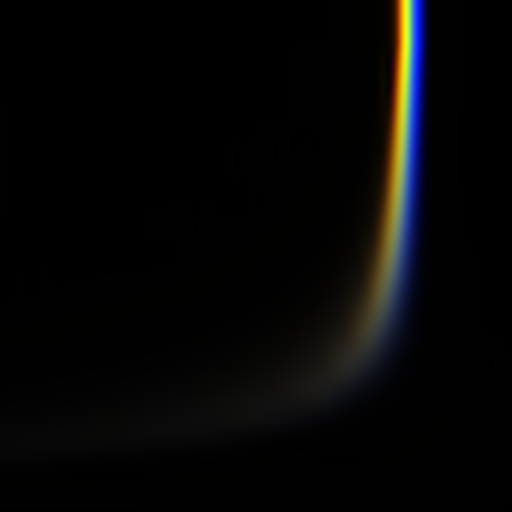

In [ ]:
image_ex

In [ ]:
image_ex.size

(512, 512)

let's create the dataset using the *Dataset* module

In [ ]:
class DataGravGan(Dataset):
    def __init__(self, path_to_data, transform=None):
        self.path_to_data = Path(path_to_data)
        self.transform = transform
        self.list_of_images = list(self.path_to_data.glob('*.tiff'))
        
    def __getitem__(self, i):
        img = Image.open(self.list_of_images[i])
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img
    
    def __len__(self):
        return len(self.list_of_images)

In [ ]:
tfms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [ ]:
GW_dataset = DataGravGan(DATA_PATH, transform=tfms)

In [ ]:
GW_dataset[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
GW_dataset[0].shape

torch.Size([3, 64, 64])

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

20

In [ ]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
BATCH_SIZE = 128

dataloader = DataLoader(GW_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

In [ ]:
EPOCH_NUM = 101

net_G = Generator().to(device)
net_G.apply(weight_init)

net_D = Discriminator().to(device)
net_D.apply(weight_init)

print('')

# Training iteration

1. Train the discriminator with the real data and recognize it as real.
2. Train the discriminator with the fake data and recognize it as fake.
3. Train the generator with the fake data and recognize it as real.

The first two steps let the discriminator learn how to tell the difference between real data and fake data. The third step teaches the generator how to confuse the discriminator with generated samples:

In [ ]:
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

G_loss_hst = {}
D_loss_hst = {}

for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader):
        x_real = data.to(device)
        real_label = torch.full((x_real.size(0),), REAL_LABEL, device=device).float()
        fake_label = torch.full((x_real.size(0),), FAKE_LABEL, device=device).float()
        
        # update D with real data
        net_D.zero_grad(set_to_none=True)
        y_real = net_D(x_real)
        loss_D_real = criterion(y_real, real_label)
        loss_D_real.backward()
        
        # update D with fake data
        z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
        x_fake = net_G(z_noise)
        #no need to update the G network, why the detach
        y_fake = net_D(x_fake.detach())
        loss_D_fake = criterion(y_fake, fake_label)
        D_loss_hst[epoch] = (loss_D_real + loss_D_fake) / 2
        loss_D_fake.backward()
        optimizer_D.step()
        
        # update G with fake data
        net_G.zero_grad(set_to_none=True)
        y_fake_r = net_D(x_fake)
        loss_G = criterion(y_fake_r, real_label)
        G_loss_hst[epoch] = loss_G
        loss_G.backward()
        optimizer_G.step()
        
        if i % 5 == 0:
            print(f'Epoch {epoch} [{i}/{len(dataloader)}] loss_D_real: {loss_D_real.mean().item():.4f}, loss_D_fake: {loss_D_fake.mean().item():.4f}, loss_G: {loss_G.mean().item():.4f}')

        if epoch % 10 == 0:
            vutils.save_image(x_real, os.path.join(OUT_PATH, 'real_samples.png'), normalize=True)
            with torch.no_grad():
                viz_sample = net_G(viz_noise)
                vutils.save_image(viz_sample, os.path.join(OUT_PATH, f'fake_samples_{epoch}.png'), normalize=True)
                if epoch % 20 == 0:
                    torch.save(net_G.state_dict(), os.path.join(OUT_PATH, f'net_G_{epoch}.pth'))
                    torch.save(net_D.state_dict(), os.path.join(OUT_PATH, f'net_D_{epoch}.pth'))

Epoch 0 [0/15] loss_D_real: 0.4658, loss_D_fake: 0.7893, loss_G: 0.8531
Epoch 0 [5/15] loss_D_real: 0.4587, loss_D_fake: 0.9136, loss_G: 0.7400
Epoch 0 [10/15] loss_D_real: 0.4751, loss_D_fake: 0.9112, loss_G: 0.7669
Epoch 1 [0/15] loss_D_real: 0.4864, loss_D_fake: 0.8574, loss_G: 0.7800
Epoch 1 [5/15] loss_D_real: 0.4806, loss_D_fake: 0.9264, loss_G: 0.7618
Epoch 1 [10/15] loss_D_real: 0.4513, loss_D_fake: 0.8889, loss_G: 0.7604
Epoch 2 [0/15] loss_D_real: 0.5253, loss_D_fake: 0.9029, loss_G: 0.7176
Epoch 2 [5/15] loss_D_real: 0.4704, loss_D_fake: 0.8409, loss_G: 0.7899
Epoch 2 [10/15] loss_D_real: 0.4923, loss_D_fake: 0.7963, loss_G: 0.8705
Epoch 3 [0/15] loss_D_real: 0.4934, loss_D_fake: 0.8728, loss_G: 0.7885
Epoch 3 [5/15] loss_D_real: 0.4608, loss_D_fake: 0.9912, loss_G: 0.7032
Epoch 3 [10/15] loss_D_real: 0.4520, loss_D_fake: 0.8922, loss_G: 0.7087
Epoch 4 [0/15] loss_D_real: 0.4904, loss_D_fake: 0.8659, loss_G: 0.8158
Epoch 4 [5/15] loss_D_real: 0.4733, loss_D_fake: 0.9708, los

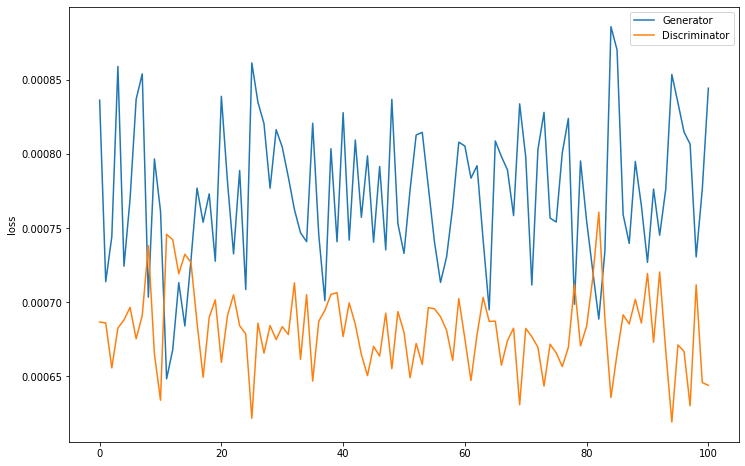

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot([i.item()/1000 for i in G_loss_hst.values()], label='Generator')
plt.plot([i.item()/1000 for i in D_loss_hst.values()], label='Discriminator')
plt.ylabel('loss')
plt.legend(loc='best');